In [1]:
using Distributions, LinearAlgebra, Plots, Random, LargeMessageCollider
Random.seed!(0);

┌ Info: Precompiling LargeMessageCollider [7f03d5f0-357e-4842-abc9-7001c0bc8a0e]
└ @ Base loading.jl:1278


In [2]:
# Generate a synthetic data
A = [1 0.1; 0 1]
B = [1 0]
Q = [0.1^3/3 0.1^2/2; 0.1^2/2 0.1]
R = 1

T = 20

x_real = zeros(2,T)
y_real = zeros(T)

x_real[:,1] = rand(MvNormal(zeros(2),diagm(0=>ones(2))))
y_real[1] = rand(Normal((B*x_real[:,1])[1],R))
for t=2:T
    x_real[:,t] = rand(MvNormal(A*x_real[:,t-1],Q))
    y_real[t] = rand(Normal((B*x_real[:,t])[1],R))
end

In [3]:
# Filtering

p1 = MvNormal(zeros(2),diagm(0=>ones(2))) # prior distribution

forward_estimates = Array{MvNormal}(undef, T)
measure = B\Normal(y_real[1],R) # measurement belief 
forward_estimates[1] = p1 * measure # update step

for t=2:T
    predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Q) # prediction belief
    measure = B\Normal(y_real[t],R) # measurement belief
    forward_estimates[t] = predict * measure # update step
end

In [4]:
# Smoothing

smooth_estimates = Array{MvNormal}(undef, T)
smooth_estimates[T] = forward_estimates[T]

joint_dists = Array{MvNormal}(undef, T-1)

for t=T-1:-1:1
    smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,inv(Q))
end

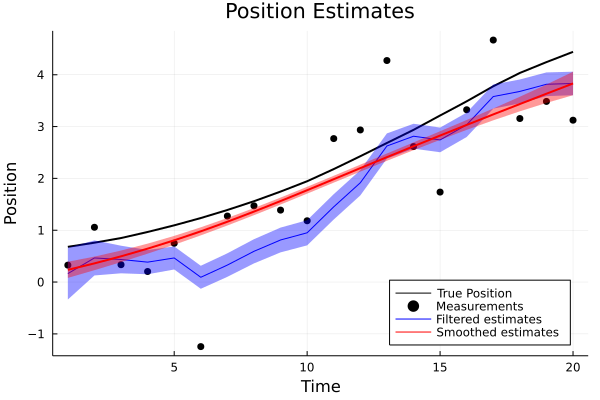

In [5]:
# Plot
y_filter_m, y_filter_v = zeros(T), zeros(T)
y_smooth_m, y_smooth_v = zeros(T), zeros(T)
for t=1:T
    y_filter_m[t] = mean(forward_estimates[t])[1]
    y_filter_v[t] = cov(forward_estimates[t])[1,1]
    y_smooth_m[t] = mean(smooth_estimates[t])[1]
    y_smooth_v[t] = cov(smooth_estimates[t])[1,1]
end

plot(x_real[1,:], color=:black, lw=2, title="Position Estimates", xaxis="Time", yaxis="Position", label="True Position")
scatter!(collect(1:T), y_real, color=:black, xaxis="Time", yaxis="Position", label="Measurements")
plot!(y_filter_m, color=:blue, ribbon=y_filter_v, fillalpha=0.4, label="Filtered estimates")
plot!(y_smooth_m, lw=2, color=:red, ribbon=y_smooth_v, fillalpha=0.4, label="Smoothed estimates", legend=:bottomright)